In [11]:
pip install pandas torch torchvision nibabel opencv-python timm scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
# HRNet

# loading all libraries used
import pandas as pd # for handling tabular data
import os # for interacting with file system
import torch # PyTorch library
from torch.utils.data import Dataset, DataLoader # for dataset and batching
from torchvision import transforms # for applying image transformation (data augmentation)
from PIL import Image # for image loading and applying the transforms
import numpy as np # for numerical operations
import nibabel as nib # For loading medical imaging files (.hdr and .img files)
from sklearn.model_selection import train_test_split # for splitting the data into train and test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc # metrics used for evaluation of the model
import matplotlib.pyplot as plt # for plotting and visualisations
import cv2 # for image processing
import timm # For loading the pretrained model
import torch.nn as nn # layers of the Neural Network
import torch.optim as optim # using the AdamW optimizer and the scheduler
import time # To measure training time
import csv # to write metrics into a csv file
from torchvision.transforms.functional import gaussian_blur # additional transform to add blurring

In [13]:
# loading csv file with all paths to the MRI files and subject information
df = pd.read_csv(r"C:\Users\gjkku\OneDrive\Documenten\CSAI year 3\Thesis\csv_binary\binary_with_mri_paths.csv", sep='\t')

# columns of the csv file to understand the structure of the dataset
print(df.columns)

# using only subjects that are non-demented (CDR 0) and very mild demented (CDR 0.5) 
df = df[df['CDR'].isin([0.0, 0.5])].dropna(subset=['CDR'])

# converting to binary labels: CDR 0 = 0 and CDR 0.5 = 1
df['label'] = df['CDR'].apply(lambda x: 0 if x == 0.0 else 1)

# printing the first 5 subjects with CDR 0 or CDR 0.5 and the count of each class to check
print(df[['CDR', 'label']].head())
print(df['label'].value_counts())

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Class', 'MRI_Path'],
      dtype='object')
   CDR  label
0  0.0      0
1  0.0      0
2  0.5      1
8  0.0      0
9  0.0      0
label
0    135
1     70
Name: count, dtype: int64


In [14]:
# dataset is imbalanced -> oversampling the minority class (CDR 0.5 / label 1) to match the majority class (CDR 0/ label 0)
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1].sample(n=135, replace=True, random_state=42)

# combining both classes and shuffle the dataset
balanced_df = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

#printing class counts to check if dataset is balanced
print(balanced_df['label'].value_counts())

label
0    135
1    135
Name: count, dtype: int64


In [15]:
# dataset split into 80% train/20% validation
train_set, validation_set = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=42) # stratify -> equal numbers of each class

# distribution of the train dataset
print("Train set class distribution:")
print(train_set['label'].value_counts())

# distribution of the validation dataset
print("\nValidation set class distribution:")
print(validation_set['label'].value_counts())

Train set class distribution:
label
0    108
1    108
Name: count, dtype: int64

Validation set class distribution:
label
0    27
1    27
Name: count, dtype: int64


In [16]:
# function to load and preprocess MRI files (.img/.hdr files)
def MRI_slicing(img_path, target_size=(224, 224), axis_slice=1):
    # loading .img/.hdr file (NiBabel finds the img and then automatically finds the .hdr file that belongs to it)
    img = nib.load(img_path)
    data = img.get_fdata()
    
    # normalizing the image using z-score normalization -> formula = (X - mean)/ std.dev
    data = (data - np.mean(data)) / np.std(data)
    
    # getting the coronal slice of the 3D MRI image (axis_slice: sagittal = 0, coronal = 1, axial = 2)
    middle_slice = data.shape[axis_slice] // 2
    if axis_slice == 0: 
        image_slice = data[middle_slice, :, :]
    elif axis_slice == 1:
        image_slice = data[:, middle_slice, :]
    else:
        image_slice = data[:, :, middle_slice]
    
    # resizing image to (224, 224) using OpenCV
    image_slice = cv2.resize(image_slice, target_size, interpolation=cv2.INTER_AREA)
    
    # normalizing pixel values between the range [0, 1]
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # returns the 2D image slice as a float32 array
    return image_slice.astype(np.float32)
    

In [17]:
# implementing a PyTorch dataset for loading images and labels
class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None, axis_slice=1):
        # initialize with a dataframe, transforms, and the axis for slicing
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.axis_slice = axis_slice
    
    def __len__(self):
        # returns the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, i):
        # getting the i-th sample: image path + label
        row = self.data.iloc[i]
        img_path = row['MRI_Path']  
        label = int(row['label'])

        # using the slicing function to load and preprocess the image
        image_slice = MRI_slicing(img_path, axis_slice=self.axis_slice)

        # convert the grayscale images to RGB, else the pretrained models can't use it
        image_slice = np.stack([image_slice]*3, axis=-1)  # (H, W, 3)

        # applying transforms/data augmentation (transforms are getting defined in a later cell)
        if self.transform:
            image_slice = self.transform(Image.fromarray((image_slice * 255).astype(np.uint8)))
            
        # returning an image tensor with the assigned label
        return image_slice, label

In [18]:
# data augmentation

# transform for training using flipping, rotating, affine, color jitter, normalizing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# transform that uses noise for training (This is used after epoch 10 as defined in the training loop)
transform_with_noise = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
    # data augmentation for testing robustness
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)), # gaussian blur
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)) # random noise
])

# validation transform using only normalizing (no noise for validation set)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [19]:
# creating the PyTorch dataset for training and validation
train_dataset = MRIDataset(train_set, transform=transform)
val_dataset = MRIDataset(validation_set, transform=val_transform) # -> no noise for the validation set

# using the PyTorch dataloader to create batches and shuffling the batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [20]:
# using GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# laoding pretrained HRNet w18 for binary classification with timm library
model = timm.create_model("hrnet_w18", pretrained=True, num_classes=2)

# freeze early layers (stage 1) to prevent overfitting
for name, param in model.named_parameters():
    if 'stage1' in name:
        param_requires_grad = False

# modifying classifier head with dropout for regularization
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # dropout regulation -> randomly selected neurons are ignored during training -> helps generalizing
    nn.Linear(model.classifier.in_features, 2)
)

# moving model to specified device
model = model.to(device)

In [21]:
# loss -> cross-entropy loss with label smoothing for binary classification
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

# optimizer -> AdamW with learning rate and weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# learning rate scheduler: ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [22]:
# function to train and evaluate the model
def train(model, train_loader, validation_loader, loss_function, optimizer, scheduler, device, epochs=50):
    
    # keeping track of the best model to save it
    best_val_accuracy = 0
    
    # training loop
    for epoch in range(epochs):
        # using noisy training data after epoch 10 
        if epoch == 10:
            print("Noisy training data is now being used")
            train_dataset.transform = transform_with_noise
            
        # training mode keeping track of total loss over each epoch and calculating accuracy for each epoch
        model.train()
        loss_over_epoch = 0.0
        correct, total = 0, 0

        # iterate over training batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # forward pass, computing loss, backpropagation to compute gradients and updating the weights of the model
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # tracking loss and accuracy
            loss_over_epoch += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # computing train accuracy 
        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_over_epoch:.4f} - Train accuracy: {train_accuracy:.2f}%")

        
        # evaluation mode
        model.eval()
        val_correct, val_total = 0, 0

        # lists to store all predictions, true labels, and probabilities for computing metrics of the validation set
        predictions = []
        true_labels = []
        probabilities = []

        # iterate over validation batches (without gradient computation)
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                # raw logits of the model 
                outputs = model(images)

                # computing probabilities for class 1 (CDR 0.5) using softmax and predictions using argmax
                probs = torch.softmax(outputs, dim=1)[:, 1] # -> probability of class 1 (CDR 0.5)
                preds = torch.argmax(outputs, dim=1) 

                # storing the predictions, true labels, and probabilities into the lists
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())
                
                
        # metrics (accuracy, precision, recall, F1-score, AUC)
        validation_accuracy = 100 * (np.array(predictions) == np.array(true_labels)).sum() / len(true_labels)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        auc = roc_auc_score(true_labels, probabilities)

        # saving the best model if it improved the validation accuracy
        if validation_accuracy > best_val_accuracy:
            best_val_accuracy = validation_accuracy
            torch.save(model.state_dict(), 'HRNet_best_model.pth')
            print("The best model is saved")

        # printing metrics of each epoch
        print(f"Validation Accuracy: {validation_accuracy:.2f}%")
        print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | AUC: {auc:.2f}\n")

        # step if AUC plateaus
        scheduler.step(auc)

##########################################################################################################################

    # load the best model to re-evaluate and save metrics of best model
    best_model_path = r"C:\Users\gjkku\HRNet_best_model.pth"
    if os.path.exists(best_model_path):
        point = torch.load(best_model_path, map_location=device)
        model.load_state_dict(point)
        model.eval()
    else:
        raise FileNotFoundError(f"file not found")

    predictions = []
    true_labels = []
    probabilities = []

    # iterate over validation batches (without gradient computation)
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            # raw logits of the model 
            outputs = model(images)

            # computing probabilities for class 1 (CDR 0.5) using softmax and predictions using argmax
            probs = torch.softmax(outputs, dim=1)[:, 1] # -> probability of class 1 (CDR 0.5)
            preds = torch.argmax(outputs, dim=1) 

            # storing the predictions, true labels, and probabilities into the lists
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
                
                
    # metrics (accuracy, precision, recall, F1-score, AUC)
    validation_accuracy = 100 * (np.array(predictions) == np.array(true_labels)).sum() / len(true_labels)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probabilities)
        
    # SQ1: saving the detection accuracy and other metrics into a CSV file
    sq1 = {
        "model": "HRNet_w18",
        "validation accuracy": round(validation_accuracy * 100, 2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2),
        "auc": round(auc, 2)
    }

    with open("SQ1_HRNet.csv", "a", newline='', encoding='utf-8') as f:
        w = csv.DictWriter(f, fieldnames=list(sq1.keys()))
        if f.tell() == 0:
           w.writeheader()
        w.writerow(sq1)

    # returning true labels and probabilities
    return true_labels, probabilities

In [27]:
# keeping track of time (start-time)
start_time = time.time()

# training model for 50 epochs
true_labels, probabilities = train(model, train_loader, validation_loader, loss_function, optimizer, scheduler, device, epochs=50)

# keeping track of time (end-time)
end_time = time.time()

Epoch 1/50 - Loss: 5.1711 - Train accuracy: 49.07%
The best model is saved
Validation Accuracy: 50.00%
Precision: 0.50 | Recall: 1.00 | F1: 0.67 | AUC: 0.74

Epoch 2/50 - Loss: 4.6954 - Train accuracy: 59.72%
The best model is saved
Validation Accuracy: 74.07%
Precision: 0.76 | Recall: 0.70 | F1: 0.73 | AUC: 0.86

Epoch 3/50 - Loss: 4.2103 - Train accuracy: 71.30%
The best model is saved
Validation Accuracy: 81.48%
Precision: 0.77 | Recall: 0.89 | F1: 0.83 | AUC: 0.84

Epoch 4/50 - Loss: 4.0269 - Train accuracy: 74.07%
The best model is saved
Validation Accuracy: 85.19%
Precision: 0.91 | Recall: 0.78 | F1: 0.84 | AUC: 0.89

Epoch 5/50 - Loss: 3.4431 - Train accuracy: 79.17%
Validation Accuracy: 75.93%
Precision: 0.68 | Recall: 0.96 | F1: 0.80 | AUC: 0.87

Epoch 6/50 - Loss: 3.3456 - Train accuracy: 81.94%
Validation Accuracy: 85.19%
Precision: 0.95 | Recall: 0.74 | F1: 0.83 | AUC: 0.90

Epoch 7/50 - Loss: 3.1310 - Train accuracy: 83.80%
The best model is saved
Validation Accuracy: 87.0

In [26]:
# SQ2: calculating inference time, memory usage, and overall resource consumption and saving it into a CSV file

# load the best model
best_model_path = r"C:\Users\gjkku\HRNet_best_model.pth"
if os.path.exists(best_model_path):
    point = torch.load(best_model_path, map_location=device)
    model.load_state_dict(point)
    model.eval()
else:
    raise FileNotFoundError(f"file not found")        

# computing average inference time
sample = next(iter(validation_loader))[0][0].unsqueeze(0).to(device)
with torch.no_grad():
    inf_start = time.time()
    for _ in range(100):
        _ = model(sample)
    inf_end = time.time()
    

sq2 = {
    "model": "HRNet_w18",
    #"training_time_sec": round(end_time - start_time, 2), This line is commented, because changes were made after kernel restarted, uncomment after training the model to evaluate training time.
    "model_parameters": sum(p.numel() for p in model.parameters()),
    "model_size_MB": round(os.path.getsize('HRNet_best_model.pth') / (1024 * 1024), 2),
    "avg_inference_time_s": round((inf_end - inf_start)/100, 4)
}

# saving the metrics for SQ2 into a CSV file
with open("SQ2_HRNet.csv", "a", newline='') as f:
    w = csv.DictWriter(f, fieldnames=sq2.keys())
    if f.tell() == 0:
       w.writeheader()
    w.writerow(sq2)

In [34]:
# SQ3: evaluating robustness by adding noise and blur to validation data

best_model_path = r"C:\Users\gjkku\HRNet_best_model.pth"
if os.path.exists(best_model_path):
    point = torch.load(best_model_path, map_location=device)
    model.load_state_dict(point)   
else:
    raise FileNotFoundError(f"file not found")
    
def robustness_test(model, loader, noise_std=0.2, blur=False):
    # evaluation mode
    model.eval()
    
    # lists to store all predictions, true labels, and probabilities for computing metrics of the validation set
    predictions = []
    true_labels = []
    probabilities = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # adding noise
            if noise_std > 0:
                images = torch.clamp(images + torch.randn_like(images) * noise_std, 0., 1.)
            # adding blur
            if blur:
                images = torch.stack([gaussian_blur(img, kernel_size=3) for img in images])
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, 1)

            # storing the predictions, true labels, and probabilities into the lists
            probabilities.extend(probs.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # returning the metrics
    return {
        "acc": accuracy_score(true_labels, predictions),
        "precision": precision_score(true_labels, predictions, average='macro', zero_division=0),
        "recall": recall_score(true_labels, predictions, average='macro', zero_division=0),
        "f1": f1_score(true_labels, predictions, average='macro', zero_division=0),
        "auc": roc_auc_score(true_labels, probabilities) if len(set(true_labels)) > 1 else 0.0
    }

# Run robustness tests
test_types = [
    # only noise
    {"type": "noise", "args": {"noise_std": 0.2, "blur": False}},
    # only blur
    {"type": "blur", "args": {"noise_std": 0.0, "blur": True}},
    # both
    {"type": "noise+blur", "args": {"noise_std": 0.2, "blur": True}}
]

with open("SQ3_HRNet.csv", "a", newline='') as f:
    w = csv.DictWriter(f, fieldnames=["model", "type", "acc", "precision", "recall", "f1", "auc"])
    if f.tell() == 0:
        w.writeheader()
    for test in test_types:
        result = robustness_test(model, validation_loader, **test["args"])
        w.writerow({"model": "HRNet_w18", "type": test["type"], **result})


<Figure size 800x600 with 0 Axes>

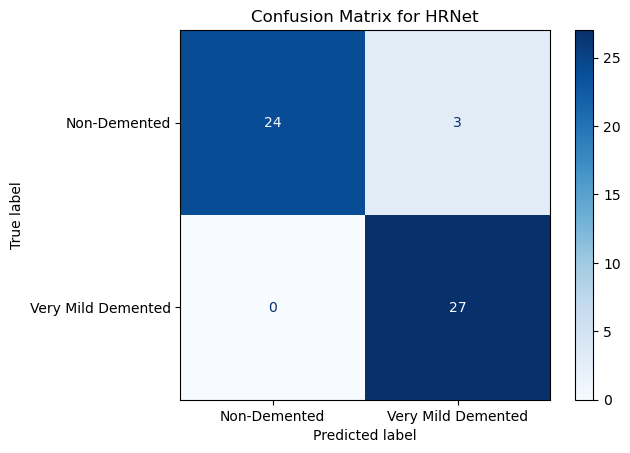

In [31]:
best_model_path = r"C:\Users\gjkku\HRNet_best_model.pth"
if os.path.exists(best_model_path):
    point = torch.load(best_model_path, map_location=device)
    model.load_state_dict(point)
    model.eval()
else:
    raise FileNotFoundError(f"Best model file not found at {best_model_path}")

# lists to store all true labels and predictions
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# computation of the confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Demented', 'Very Mild Demented'])

# confusion matrix plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for HRNet')
plt.savefig('HRNet_confusion_matrix.png')  
plt.show()  
plt.close()